# Intro 
We want to analyse cafe sales to provide valuable insights into customer behavior, product popularity and revenue patterns.

# Step 1. Read & Inspect Dataframe

In [107]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Read csv
df = pd.read_csv("/kaggle/input/cafe-sales-dirty-data-for-cleaning-training/dirty_cafe_sales.csv")
# Copy dataset for cleaning
df_clean = df.copy()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


# Step 2. Perform data cleaning
* Convert total spent, quantity and price per unit columns to numeric data type
* Populate missing values for total spent, quantity and price per unit
* Convert transaction date to datetime data type
* Add column transaction month
* Populate missing values for payment method based on the most common method for each total spent value

In [108]:
# Unique prices dict
unique_prices = {
    'Cookie': 1.0,
    'Tea': 1.5,
    'Coffee': 2.0,
    'Salad': 5.0
}

# Non unique Prices dict
non_unique_prices = {
    'Juice': 3.0,
    'Cake': 3.0,
    'Sandwich': 4.0,
    'Smoothie': 4.0
}

# Combined prices dict
prices = unique_prices | non_unique_prices

# Convert to numeric
df_clean[['Total Spent', 'Quantity', 'Price Per Unit']] = df_clean[['Total Spent', 'Quantity', 'Price Per Unit']].apply(pd.to_numeric, errors='coerce', axis=1)

# Populate Price Per Unit (1.Based on Item, 2.Total Spent / Quantity)
df_clean['Price Per Unit'] = df_clean.apply(lambda row: prices.get(row['Item']) if pd.isna(row['Price Per Unit']) else row['Price Per Unit'], axis=1)
df_clean['Price Per Unit'] = df_clean.apply(lambda row: row['Total Spent'] / row['Quantity'] if pd.isna(row['Price Per Unit']) else row['Price Per Unit'], axis=1)
# Drop rows where Price Per Unit is NaN (6 rows)
df_clean.dropna(subset=['Price Per Unit'], inplace=True)
# Drop rows where Total Spent & Quantity is NaN (20 rows)
df_clean.dropna(subset=['Total Spent', 'Quantity'], how='all', inplace=True)

# Populate Total Spent (Quantity * Price Per Unit)
df_clean['Total Spent'] = df_clean.apply(lambda row: row['Quantity'] * row['Price Per Unit'] if pd.isna(row['Total Spent']) else row['Total Spent'], axis=1)

# Populate Quantity (Total Spent / Price Per Unit)
df_clean['Quantity'] = df_clean.apply(lambda row: row['Total Spent'] * row['Price Per Unit'] if pd.isna(row['Quantity']) else row['Quantity'], axis=1)

# Convert UNKNOWN & ERROR items to NaN (963 rows)
df_clean['Item'] = df_clean['Item'].replace({'UNKNOWN': np.nan, 'ERROR': np.nan})
df_clean[df_clean['Item'].isna()]
# Populate Item (Based on unique prices) 
df_clean['Item'] = df_clean.apply(lambda row: next((k for k, v in unique_prices.items() if v == row['Price Per Unit']), row['Item']), axis=1)

# Convert to date 
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], errors='coerce')
# Drop rows where Transaction Date is NaN
df_clean.dropna(subset=['Transaction Date'], inplace=True)
# Add new column 'Transaction Month'
df_clean['Transaction Month'] = pd.to_datetime(df_clean['Transaction Date']).dt.strftime('%B')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9514 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Transaction ID     9514 non-null   object        
 1   Item               9064 non-null   object        
 2   Quantity           9514 non-null   float64       
 3   Price Per Unit     9514 non-null   float64       
 4   Total Spent        9514 non-null   float64       
 5   Payment Method     7084 non-null   object        
 6   Location           6404 non-null   object        
 7   Transaction Date   9514 non-null   datetime64[ns]
 8   Transaction Month  9514 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 743.3+ KB


In [109]:
# Get unique payment method values 
df_clean['Payment Method'].unique()

# Convert UNKNOWN & ERROR payment methods to NaN 
df_clean['Payment Method'] = df_clean['Payment Method'].replace({'UNKNOWN': np.nan, 'ERROR': np.nan})

# Group Total Spent by most common Payment Method
payment_method_mode = df_clean.groupby('Total Spent')['Payment Method'].agg(lambda x: x.mode()[0])
payment_method_mode

Total Spent
1.0        Credit Card
1.5     Digital Wallet
2.0     Digital Wallet
3.0               Cash
4.0        Credit Card
4.5               Cash
5.0               Cash
6.0     Digital Wallet
7.5        Credit Card
8.0        Credit Card
9.0               Cash
10.0       Credit Card
12.0       Credit Card
15.0    Digital Wallet
16.0              Cash
20.0    Digital Wallet
25.0       Credit Card
Name: Payment Method, dtype: object

In [110]:
# First 5 rows where Payment Method is NaN 
df_clean[df_clean['Payment Method'].isna()].head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Transaction Month
3,TXN_7034554,Salad,2.0,5.0,10.0,NaN,UNKNOWN,2023-04-27,April
6,TXN_4433211,NaN,3.0,3.0,9.0,NaN,Takeaway,2023-10-06,October
8,TXN_4717867,NaN,5.0,3.0,15.0,NaN,Takeaway,2023-07-28,July
9,TXN_2064365,Sandwich,5.0,4.0,20.0,NaN,In-store,2023-12-31,December
13,TXN_9437049,Cookie,5.0,1.0,5.0,NaN,Takeaway,2023-06-01,June


In [111]:
# Populate missing Payment Method with most common value
df_clean['Payment Method'] = df_clean.apply(lambda row: payment_method_mode[row['Total Spent']] if pd.isna(row['Payment Method']) else row['Payment Method'], axis=1)
# Confirm the payment method mapping is correct
df_clean.iloc[[3, 6, 8, 9, 13]]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Transaction Month
3,TXN_7034554,Salad,2.0,5.0,10.0,Credit Card,UNKNOWN,2023-04-27,April
6,TXN_4433211,NaN,3.0,3.0,9.0,Cash,Takeaway,2023-10-06,October
8,TXN_4717867,NaN,5.0,3.0,15.0,Digital Wallet,Takeaway,2023-07-28,July
9,TXN_2064365,Sandwich,5.0,4.0,20.0,Digital Wallet,In-store,2023-12-31,December
14,TXN_8915701,Tea,2.0,1.5,3.0,Cash,In-store,2023-03-21,March


# Step 3. Data Aggregation

In [112]:
# Quantity Sold Per Month
df_quantities_pivot = df_clean.pivot_table(index='Transaction Month', columns='Item', values='Quantity', aggfunc='sum')
df_quantities_pivot.reset_index(inplace=True)
df_quantities_pivot['Transaction Month No'] = pd.to_datetime(df_quantities_pivot['Transaction Month'], format='%B').dt.month
df_quantities_pivot.sort_values('Transaction Month No', inplace=True)
df_quantities_pivot.drop(columns='Transaction Month No', inplace=True)

# Monthly Revenue
df_revenue_pivot = df_clean.pivot_table(index='Transaction Month', columns='Item', values='Total Spent', aggfunc='sum')
df_revenue_pivot.reset_index(inplace=True)
df_revenue_pivot['Transaction Month No'] = pd.to_datetime(df_quantities_pivot['Transaction Month'], format='%B').dt.month
df_revenue_pivot.sort_values('Transaction Month No', inplace=True)
df_revenue_pivot.drop(columns='Transaction Month No', inplace=True)
df_revenue_pivot['Monthly Revenue'] = df_revenue_pivot[list(prices.keys())].sum(axis=1)

# Revenue by Item 
revenue = df_clean.groupby('Item')['Total Spent'].agg(['sum']).sort_values(by='sum', ascending=False)

# Distribution of Total Spent across Payment Method
df_pm = pd.melt(df_clean, id_vars='Payment Method', value_vars=['Total Spent'], var_name='features', value_name='values')

df_revenue_pivot

Item,Transaction Month,Cake,Coffee,Cookie,Juice,Salad,Sandwich,Smoothie,Tea,Monthly Revenue
4,January,855.0,592.0,292.0,918.0,1665.0,1384.0,756.0,456.0,6918.0
3,February,684.0,612.0,246.0,846.0,1330.0,1016.0,1012.0,432.0,6178.0
7,March,801.0,726.0,301.0,924.0,1560.0,1176.0,988.0,432.0,6908.0
0,April,816.0,586.0,247.0,915.0,1610.0,1028.0,1148.0,393.0,6743.0
8,May,843.0,586.0,278.0,831.0,1370.0,1168.0,1048.0,382.5,6506.5
6,June,777.0,646.0,290.0,855.0,1645.0,1104.0,1140.0,417.0,6874.0
5,July,717.0,648.0,322.0,627.0,1715.0,1056.0,1056.0,418.5,6559.5
1,August,834.0,638.0,281.0,705.0,1580.0,1024.0,1052.0,475.5,6589.5
11,September,867.0,528.0,312.0,735.0,1245.0,1128.0,1172.0,450.0,6437.0
10,October,951.0,750.0,281.0,915.0,1545.0,968.0,1108.0,522.0,7040.0


# Step 4. Create Plots
Three subplots will be created to show the revenue by item, top 3 selling items, monthly revenue and distribution of total spent across payment method.

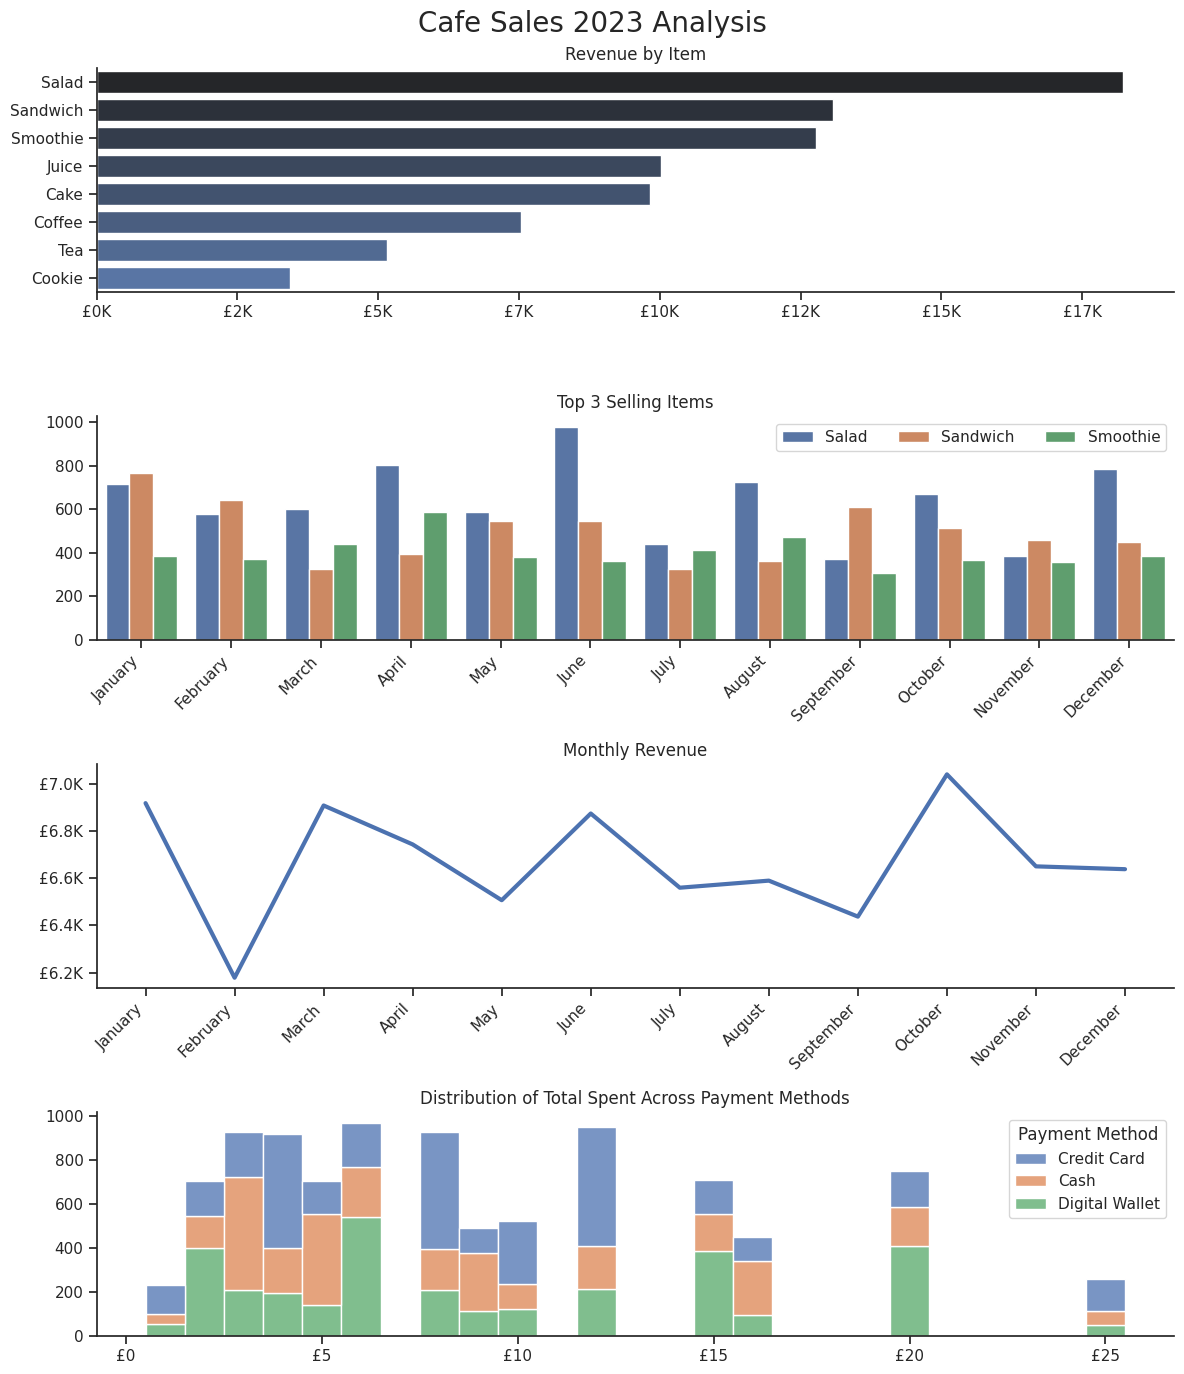

In [113]:
fig, ax = plt.subplots(4,1, figsize=(12,14))

# Revenue by Item
sns.set_theme(style='ticks')
sns.barplot(data=revenue, x='sum', y=revenue.index, palette='dark:b', ax=ax[0])
sns.despine()
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Revenue by Item')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x/1000)}K'))

# Top 3 Selling Items
top_3 = df_clean.groupby('Item')['Quantity'].agg(['sum']).sort_values(by='sum', ascending=False)
top_3 = top_3.head(3).index.tolist()
df_top_3 = df_quantities_pivot.melt(id_vars='Transaction Month', value_vars=top_3, var_name='Item', value_name='Quantity')
sns.barplot(data=df_top_3, x='Transaction Month', y='Quantity', hue='Item', ax=ax[1])
ax[1].set_title('Top 3 Selling Items')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].legend(loc='upper right', ncol=3)

# Monthly Revenue
sns.lineplot(data=df_revenue_pivot, x='Transaction Month', y='Monthly Revenue', linewidth=3, ax=ax[2])
ax[2].set_title('Monthly Revenue')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x/1000:.1f}K'))
plt.setp(ax[2].get_xticklabels(), rotation=45, ha='right')

# Distribution of Total Spent across Payment Method
sns.histplot(data=df_pm, x='values', hue='Payment Method', multiple='stack', discrete=True, ax=ax[3])
ax[3].set_title('Distribution of Total Spent Across Payment Methods')
ax[3].set_xlabel('')
ax[3].set_ylabel('')
ax[3].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x)}'))


fig.suptitle('Cafe Sales 2023 Analysis', fontsize=20)
fig.tight_layout()

# Step 5. Analysis
**Revenue by Item**
We can observe that salad generated the highest revenue, earning approximately £5k more than the second-highest item, while cookie generated the lowest revenue.

**Top 3 Selling Items**
Month by month, salad is usually the most purchased item, with sales peaking in June as summer begins. Sales dip in September, likely due to the arrival of autumn, but overall, this pattern indicates that people are health conscious. Sandwiches and smoothies are also among the top selling items, further supporting the trend of health conscious consumer choices. This aligns with the fact that the highest revenue-generating items are salads, sandwiches and smoothies.

**Monthly Revenue**
The monthly revenue consistently falls between £6k and £7k, with February being the lowest revenue month. After the festive season in December and the New Year, people tend to tighten their budgets, hence this could result in fewer visits to cafes in February. A promotion could be a good strategy to boost revenue during February, such as Valentine's-themed specials. October is the highest revenue month, suggesting that as the weather cools, people are more inclined to enjoy warm drinks. This is further supported by the fact that October's tea revenue is the highest at £522, and coffee revenue also peaks at £750.

**Distribution of Total Spent across Payment Method**
Credit card, cash, and digital wallet appear to be used equally as payment methods, regardless of the total amount spent. There is no evident pattern indicating that any particular payment method is more commonly used for larger payments. For instance, when the total spent is £20, digital wallet is the most common payment method. However, when the total spent reaches £25, both digital wallet and cash are used less frequently than credit card. Total spent may correlate with payment method for specific customer segments, such as demographics but not at a general level.